In [6]:
import numpy as np
import scipy as sp
from numpy import linalg as nla
import matplotlib.pyplot as plt

Model

In [7]:
def model(r,tc):
    x=r[0]
    y=r[1]
    z=r[2]
    rho=0.3224
    delta=0.225423
    a=7.3939+0.002*np.sin(1.8*tc)
    k=0.4032
    c=2.3952
    x1=1.0*(rho*delta*(x*x-a*x)+x*(x+y+c-c*np.tanh(x+z)))
    y1=-1.0*rho*delta*(a*y+x*x)
    z1=delta*(k-z-0.5*x)
    return (np.array([x1,y1,z1]))

In [8]:
def jac(r,tc):
    rho=0.3224
    delta=0.225423
    a=7.3939+0.002*np.sin(1.8*tc)
    k=0.4032
    c=2.3952
    x=r[0]
    y=r[1]
    z=r[2]
    M=np.array([[-c*np.tanh(x + z) + c + d*p*((-7.3939+0.002*np.sin(1.8*tc)) + 2*x) + x*(-c*(1 - np.tanh(x + z)**2) + 1) + x + y,x,-c*x*(1 - np.tanh(x + z)**2)],
                [-2*x*p*d,-p*d*(7.3939+0.002*np.sin(1.8*tc)),0],
                [-d*0.5,0,-d]])
    return M

In [9]:
def mul(r,tc,g):
    res=np.matmul(jac(r,tc),g)
    return res

Computations

In [10]:
%%time

g=np.identity(3)
tmax=500
h=0.01
t=0
x=-3
y=0
z=0
r=np.array([x,y,z])
talp=0
talp2=0
talp3=0
valt=[]
amp1=[]
amp2=[]
amp3=[]
valx=[]
tr=[]

# Time loop
while (t<tmax):
    tc=t
    xt=r[0]
    yt=r[1]
    zt=r[2]
    Ma=jac(r,tc)
    trace=Ma.trace()
    tr.append(trace)
    
    #evolution of the perturbations along the Lyapunov directions
    l1=mul(r,tc,g)
    l2=mul(r,tc,g+0.5*h*l1)
    l3=mul(r,tc,g+0.5*h*l2)
    l4=mul(r,tc,g+h*l3)
    g=g+(1.0/6)*h*(l1+2*l2+2*l3+l4)
    
    g1=g[:,0]
    g2=g[:,1]
    g3=g[:,2]
    
    # Gram-Schmittage
    #1er exposant
    norm=np.linalg.norm(g1)
    alp=np.log(norm)/h
    talp=talp+alp
    g1=g1/norm
    
    #2eme exposant
    g2p=g2-g1*(np.dot(g2,g1))
    norm2=np.linalg.norm(g2p)
    alp2=np.log(norm2)/h
    talp2=talp2+alp2
    g2=g2p/norm2
    
    #3eme exposant
    g3p=(g3-g2*(np.dot(g3,g2))-g1*(np.dot(g3,g1)))
    norm3=np.linalg.norm(g3p)
    alp3=np.log(norm3)/h
    talp3=talp3+alp3
    g3=g3p/norm3
    
    # Gathering the new directions into a matrix
    g=np.hstack([g1[:,np.newaxis],g2[:,np.newaxis],g3[:,np.newaxis]])
    
    # Model time evolution
    k1=model(r,tc)
    k2=model(r+0.5*h*k1,tc)
    k3=model(r+0.5*h*k2,tc)
    k4=model(r+k3*h,tc)
    r=r+(1.0/6)*h*(k1+2*k2+2*k3+k4)
    t=t+h
    
    # Storing the results
    valt.append(t)
    amp1.append(alp)
    amp2.append(alp2)
    amp3.append(alp3)
    valx.append(r[0])
print (alp)
print (alp2)
print (alp3)
amp1=np.array(amp1)
amp2=np.array(amp2)
amp3=np.array(amp3)
valt=np.array(valt)
tr=np.array(tr)

0.7702576300583904
-0.6449266269235466
-0.33271641478095326
CPU times: user 16.4 s, sys: 502 ms, total: 16.9 s
Wall time: 17.7 s


<IPython.core.display.Javascript object>


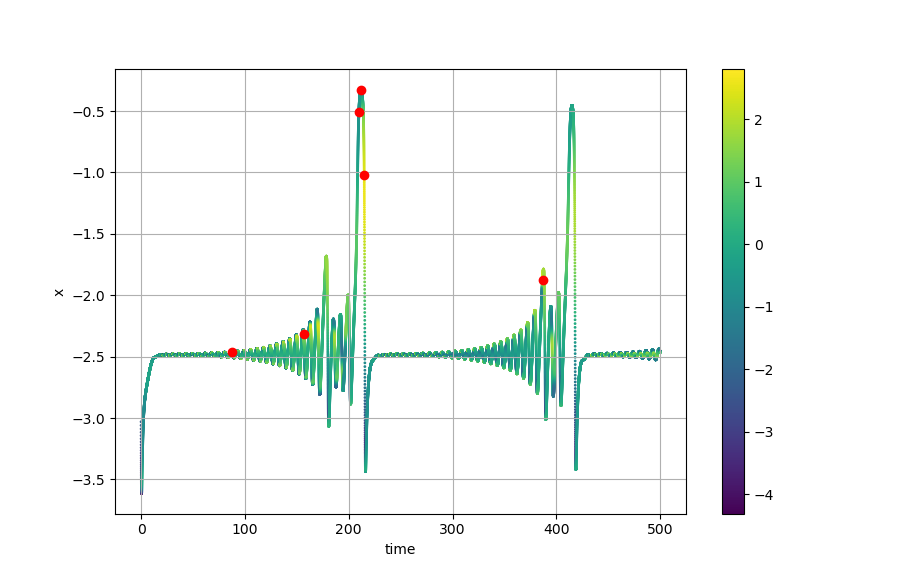

In [12]:
%matplotlib notebook
fig = plt.figure()
plt.xlabel('time')
plt.ylabel('x')
plot = plt.scatter(valt, valx, s= 1, c = amp1, cmap='viridis')
plt.plot(87.15, -2.463, 'ro')
plt.plot(156.62, -2.31435, 'ro')
plt.plot(209.82,-0.508301, 'ro')
plt.plot(211.81,-0.324628, 'ro')
plt.plot(215,-1.021,'ro')
plt.plot(386.69,-1.87748,'ro')

fig.colorbar(plot)
plt.grid(True, 'both')
plt.show()

Plots

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,6))

color = 'tab:blue'
ax1.set_xlabel('time')
ax1.set_ylabel('local exponent')
ax1.plot(valt, amp1, color=color, label='exponent 1')

color = 'tab:orange'
ax1.set_xlabel('time')
ax1.plot(valt, amp2, color=color, label='exponent 2')

color = 'tab:green'
ax1.set_xlabel('time')
ax1.plot(valt, amp3, color=color, label='exponent 3')
plt.legend()


ax2 = ax1.twinx()  

color = 'tab:red'
ax2.set_ylabel('x', color=color)  
ax2.plot(valt, valx, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,6))

color = 'tab:blue'
ax1.set_xlabel('time')
ax1.set_ylabel('local exponent')
ax1.plot(valt, amp1.cumsum()/(1.+np.arange(len(valt))), color=color, label='avg exponent 1')

color = 'tab:orange'
ax1.set_xlabel('time')
ax1.plot(valt, amp2.cumsum()/(1.+np.arange(len(valt))), color=color, label='avg exponent 2')

color = 'tab:green'
ax1.set_xlabel('time')
ax1.plot(valt, amp3.cumsum()/(1.+np.arange(len(valt))), color=color, label='avg exponent 3')
plt.legend()


ax2 = ax1.twinx()  

color = 'tab:red'
ax2.set_ylabel('x', color=color)  
ax2.plot(valt, valx, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,6))

color = 'tab:blue'
ax1.set_xlabel('time')
ax1.plot(valt, amp1+amp2+amp3, color=color, label='sum of exponent')

color = 'tab:red'
ax1.plot(valt, tr, color=color, label='trace')

plt.legend()
fig.tight_layout()  
plt.show()